# CCA SSVEP dataset
**labels:**
    0 - no flickering
    1 2 3 4 - for the boxes

**id label alphabetical:**

0 - alebs

1 - barlo

2 - yagmur

In [1]:
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.fftpack
from scipy import stats, integrate
from scipy import signal
from scipy.signal import butter, lfilter, filtfilt

from sklearn.cross_decomposition import CCA
from sklearn.feature_selection import chi2, mutual_info_classif, SelectKBest
from sklearn.model_selection import train_test_split, cross_val_score

%matplotlib inline

## Load Data

In [2]:
# load and sort the paths
path = '../data/raw/'
sampling_rate = 128

fnames = glob(path+'*.csv') # get paths and save them
fnames = [ '../data/raw/alebs-record.csv',
 '../data/raw/barlo-record.csv',
 '../data/raw/yagmur-record.csv']
fnames.sort()
fnames

['../data/raw/alebs-record.csv',
 '../data/raw/barlo-record.csv',
 '../data/raw/yagmur-record.csv']

In [3]:
electrodes_names = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4', 'label']
data = {}
for i, name in enumerate(fnames):
    data[i] = pd.read_csv(name, names=electrodes_names)
    data[i]['id'] = i
data[1].tail()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,label,id
66555,4039.9,4033.7,4141.5,4106.5,4103.2,4094.4,4122.8,4137.7,4138.7,4128.8,4123.6,4101.5,4093.6,4010.6,0,1
66556,4042.9,4030.0,4139.4,4111.2,4106.3,4094.2,4122.4,4135.1,4137.9,4128.3,4127.8,4102.4,4095.8,4012.8,0,1
66557,4081.3,4049.1,4147.9,4115.6,4108.6,4094.5,4124.6,4130.6,4126.3,4126.0,4131.2,4101.3,4093.7,4009.6,0,1
66558,4076.2,4047.7,4146.5,4115.0,4109.6,4099.6,4129.4,4133.3,4128.7,4131.0,4125.4,4100.1,4094.5,4007.1,0,1
66559,4041.0,4025.9,4136.3,4117.3,4114.1,4108.5,4136.5,4140.3,4144.4,4138.5,4121.4,4100.5,4095.8,3998.8,0,1


In [4]:
data_all = pd.DataFrame()

for i in np.arange(0,3):
    data_all = pd.concat([data_all, data[i]], axis=0, ignore_index=True)

In [5]:
carlo = data[1]
carlo.head()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,label,id
0,4252.3,4147.3,4141.2,4156.5,4167.7,4112.9,4119.7,4073.1,4121.3,4075.6,4141.3,4091.9,4102.9,4190.6,0,1
1,4264.1,4155.4,4137.4,4150.1,4159.7,4114.4,4118.1,4070.8,4118.2,4090.5,4138.1,4085.3,4113.1,4193.5,0,1
2,4257.1,4151.3,4133.8,4141.7,4161.0,4112.4,4113.8,4071.4,4113.5,4078.8,4133.7,4082.9,4108.7,4186.0,0,1
3,4230.4,4139.0,4132.3,4145.3,4174.7,4109.9,4115.1,4080.0,4111.8,4050.5,4135.8,4087.1,4090.5,4172.2,0,1
4,16914.0,16563.0,16537.0,16589.0,16692.0,16453.0,16483.0,16328.0,16473.0,16244.0,16548.0,16348.0,16376.0,16688.0,0,1


In [6]:
aleks = data[0]
aleks.head()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,label,id
0,4094.2,4093.8,4087.6,4114.6,4096.5,4099.0,4091.3,4092.2,4100.3,4125.3,4121.3,4080.4,4102.3,4093.2,0,0
1,4103.7,4108.2,4092.8,4115.4,4108.5,4105.0,4094.4,4102.8,4101.0,4122.8,4117.1,4091.0,4106.4,4096.5,0,0
2,4109.7,4113.1,4098.2,4119.1,4110.0,4111.5,4101.4,4110.1,4106.3,4133.6,4120.3,4098.7,4109.1,4102.8,0,0
3,4109.7,4115.9,4100.4,4125.9,4119.9,4107.9,4104.2,4103.8,4101.4,4140.5,4131.4,4097.6,4111.4,4106.3,0,0
4,4101.2,4112.3,4094.7,4124.5,4121.0,4100.3,4098.8,4092.8,4092.4,4131.2,4129.0,4086.3,4107.6,4098.2,0,0


In [7]:
yagmur = data[2]
yagmur.head()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,label,id
0,4119.7,4119.0,4165.4,4130.6,4119.0,4108.2,4065.0,4070.3,4103.7,4110.3,4128.6,4095.1,4121.2,4132.9,0,2
1,4121.5,4120.6,4167.8,4133.7,4118.3,4109.2,4065.8,4070.0,4106.3,4113.6,4133.6,4093.7,4127.4,4135.4,0,2
2,4121.2,4117.9,4170.3,4131.7,4121.7,4112.4,4066.0,4065.5,4104.5,4113.1,4133.6,4087.8,4120.9,4129.0,0,2
3,4120.4,4116.8,4169.4,4129.6,4125.5,4114.5,4066.8,4064.6,4101.7,4108.8,4129.9,4086.7,4113.7,4125.4,0,2
4,4114.7,4116.4,4165.8,4128.5,4124.1,4112.7,4069.7,4065.5,4101.3,4094.9,4120.6,4089.0,4107.1,4127.7,0,2


## Pick "fake yagmur"

In [8]:
yagmur = data[0]

## Applying Bandpass Filter on One Channel

In [9]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filtfilt(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return filtfilt(b, a, data) 

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [10]:
yagmur_filt = pd.DataFrame()

for col in yagmur.columns.tolist():
    yagmur_filt[col] = butter_bandpass_filtfilt( yagmur[col], 5, 30, sampling_rate)

yagmur_filt.label = yagmur.label
yagmur_filt.id = yagmur.id

yagmur_filt.head(2)


,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,label,id
0,0.077183,-0.042935,0.033925,0.044366,0.054249,0.147504,-0.022860,-0.102111,0.053889,0.134994,0.188475,0.140908,0.126763,0.157129,0,0
1,9.951102,11.219815,5.919193,0.388807,6.930242,7.067424,3.463466,11.447894,4.379738,2.358977,-2.961534,11.423183,4.205423,5.474645,0,0


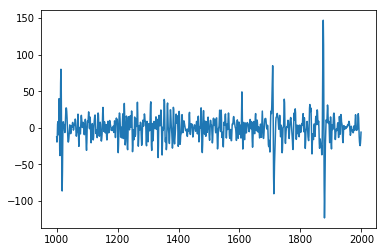

In [11]:
plt.plot(yagmur_filt.AF3[1000:2000])

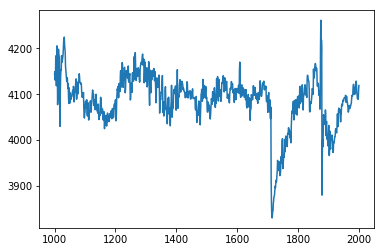

In [12]:
plt.plot(yagmur.AF3[1000:2000])

## Epochs

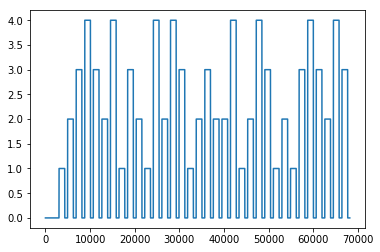

In [13]:
plt.plot(yagmur.label)

### Get Points Needed For Epochs

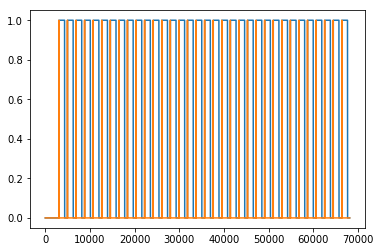

In [14]:
threshold = 0.5

idxOFF = np.argwhere(yagmur.label < threshold)
idxON = np.argwhere(yagmur.label > threshold)


x_alwaysON = np.zeros(len(yagmur.index))
x_alwaysON[idxON] = 1

x_turnON = np.roll(x_alwaysON, 1)
x_turnON = x_alwaysON - x_turnON
x_turnON = np.where(x_turnON > 0, x_turnON, 0)

plt.plot(x_alwaysON)
plt.plot(x_turnON)
plt.show()

In [15]:
y = np.zeros(len(np.argwhere(x_turnON)))
i = 0
for n in np.argwhere(x_turnON):
    y[i] = yagmur.label[n]
    i+=1
y

array([1., 2., 3., 4., 3., 2., 4., 1., 3., 2., 1., 4., 2., 4., 3., 1., 2.,
       3., 2., 2., 4., 1., 2., 4., 3., 1., 2., 1., 3., 4., 3., 2., 4., 3.])

### Pick Only Needed Electrodes

In [16]:
picked_electrodes = {'AF3', 'F3', 'AF4', 'F4', 'F7', 'F8'}

data_electr_filt = np.zeros((yagmur_filt.shape[0], len(picked_electrodes)))


for n, elec in enumerate(picked_electrodes):
    data_electr_filt[:,n] = yagmur[elec]

data_electr_filt.shape

(68160, 6)

### Epoching over all data
epochs = num trials x num data points x num electrodes
epochs concat = trials\*electrodes x data points

In [17]:
N_epoch = 700
epochs = np.zeros((len( np.argwhere(x_turnON) ),N_epoch, len(picked_electrodes))) #34x700x4 

for n, i in enumerate(np.argwhere(x_turnON)):  
    epochs[n,:,:] = data_electr_filt[i[0]+400:i[0]+400+N_epoch,:]
    

In [18]:
epochs.shape

(34, 700, 6)

## Spectrograms

3.0


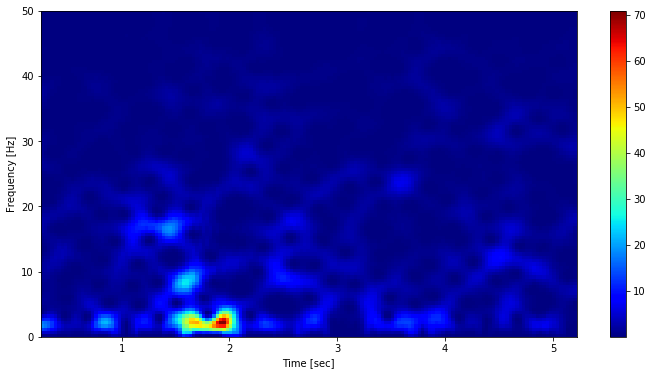

In [19]:
n=2
sample = epochs[n,:,1]
print(y[n])
f, t, Sxx = signal.spectrogram(sample, sampling_rate, nfft=256, nperseg=64,
                              window=('hamming'), noverlap=60)

plt.figure(figsize=(12,6))
plt.pcolormesh(t, f, Sxx, cmap='jet')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0,50)
plt.colorbar()

# plt.figure(figsize=(12,6))
# plt.plot(sample);


3.0


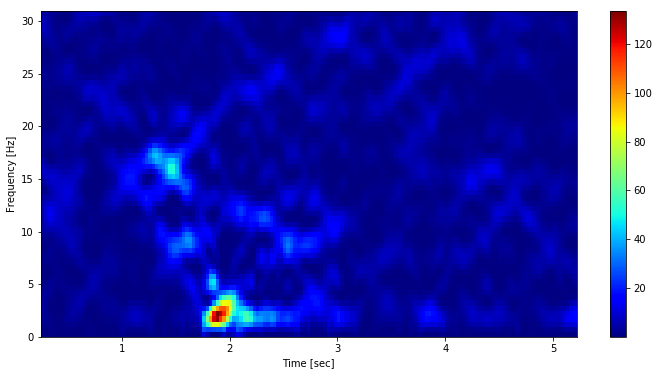

In [20]:
n=2
print(y[n])
F = np.zeros(129)

for i in np.arange(0,6):
    sample = epochs[n,:,i]
    f, t, Sxx = signal.spectrogram(sample, sampling_rate, nfft=256, nperseg=64,
                              window=('tukey', 0.5),
                              noverlap=60
                                  )
    F += f/6

F=F
plt.figure(figsize=(12,6))
plt.pcolormesh(t, F, Sxx, cmap='jet')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0,31)
plt.colorbar();

2.0


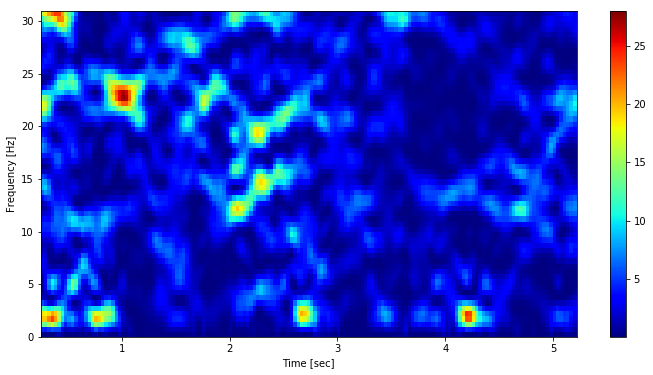

In [21]:
n=12
print(y[n])
F = np.zeros(129)

for i in np.arange(0,6):
    sample = epochs[n,:,i]
    f, t, Sxx = signal.spectrogram(sample, sampling_rate, nfft=256, nperseg=64,
                              window=('tukey', 0.5),
                              noverlap=60
                                  )
    F += f/6

F=F
plt.figure(figsize=(12,6))
plt.pcolormesh(t, F, Sxx, cmap='jet')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0,31)
plt.colorbar();

2.0


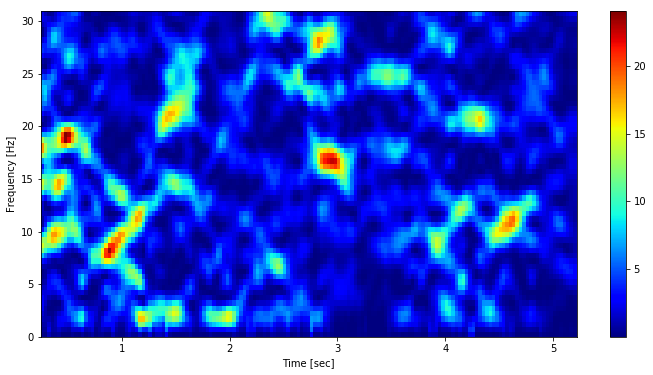

In [22]:
n=22
print(y[n])
F = np.zeros(129)

for i in np.arange(0,6):
    sample = epochs[n,:,i]
    f, t, Sxx = signal.spectrogram(sample, sampling_rate, nfft=256, nperseg=64,
                              window=('tukey', 0.5),
                              noverlap=60
                                  )
    F += f/6

F=F
plt.figure(figsize=(12,6))
plt.pcolormesh(t, F, Sxx, cmap='jet')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0,31)
plt.colorbar();

4.0


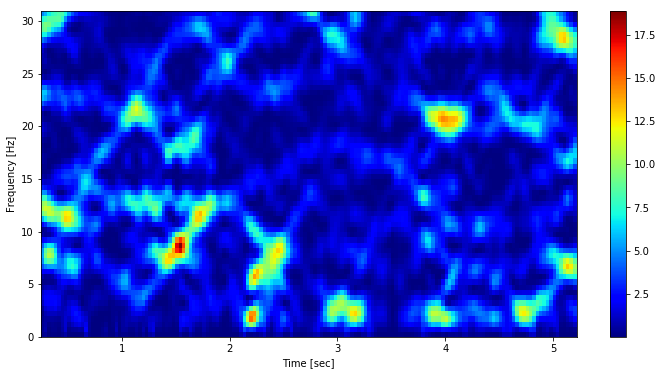

In [58]:
n=32

print(y[n])
F = np.zeros(129)

for i in np.arange(0,6):
    sample = epochs[n,:,i]
    f, t, Sxx = signal.spectrogram(sample, sampling_rate, nfft=256, nperseg=64,
                              window=('tukey', 0.5),
                              noverlap=60
                                  )
    F += f/6

F=F
plt.figure(figsize=(12,6))
plt.pcolormesh(t, F, Sxx, cmap='jet')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0,31)
plt.colorbar();

In [24]:
signal.get_window?


Signature: signal.get_window(window, Nx, fftbins=True)
Docstring:
Return a window.

Parameters
----------
window : string, float, or tuple
    The type of window to create. See below for more details.
Nx : int
    The number of samples in the window.
fftbins : bool, optional
    If True (default), create a "periodic" window, ready to use with
    `ifftshift` and be multiplied by the result of an FFT (see also
    `fftpack.fftfreq`).
    If False, create a "symmetric" window, for use in filter design.

Returns
-------
get_window : ndarray
    Returns a window of length `Nx` and type `window`

Notes
-----
Window types:

    `boxcar`, `triang`, `blackman`, `hamming`, `hann`, `bartlett`,
    `flattop`, `parzen`, `bohman`, `blackmanharris`, `nuttall`,
    `barthann`, `kaiser` (needs beta), `gaussian` (needs standard
    deviation), `general_gaussian` (needs power, width), `slepian`
    (needs width), `dpss` (needs normalized half-bandwidth),
    `chebwin` (needs attenuation), `exponential` 